In [102]:

from ultralytics import YOLO
import cv2
from IPython.display import display
from IPython.display import Image as  Image_DIS
from PIL import Image as Image_PIL
from util import postprocess, preprocess_image, image_to_tensor, draw_results
import numpy as np
from ultralytics.utils.metrics import ConfusionMatrix
import torch
from notebook_utils import  VideoPlayer

In [104]:
def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    print("Boxes:")
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))
    if 'metrics/precision(M)' in stats:
        s_mp, s_mr, s_map50, s_mean_ap = stats['metrics/precision(M)'], stats['metrics/recall(M)'], stats['metrics/mAP50(M)'], stats['metrics/mAP50-95(M)']
        # Print results
        s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
        print(s)
        pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
        print(pf % ('all', total_images, total_objects, s_mp, s_mr, s_map50, s_mean_ap))



image 1/1 /home/bdi/Mammo_FDA/TensorRT/dataset/valid/images/frame8620_jpg.rf.9efee68b98f7b1bd96dc8ba72a547a2a.jpg: 384x640 1 xe1banh, 81.4ms
Speed: 2.9ms preprocess, 81.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


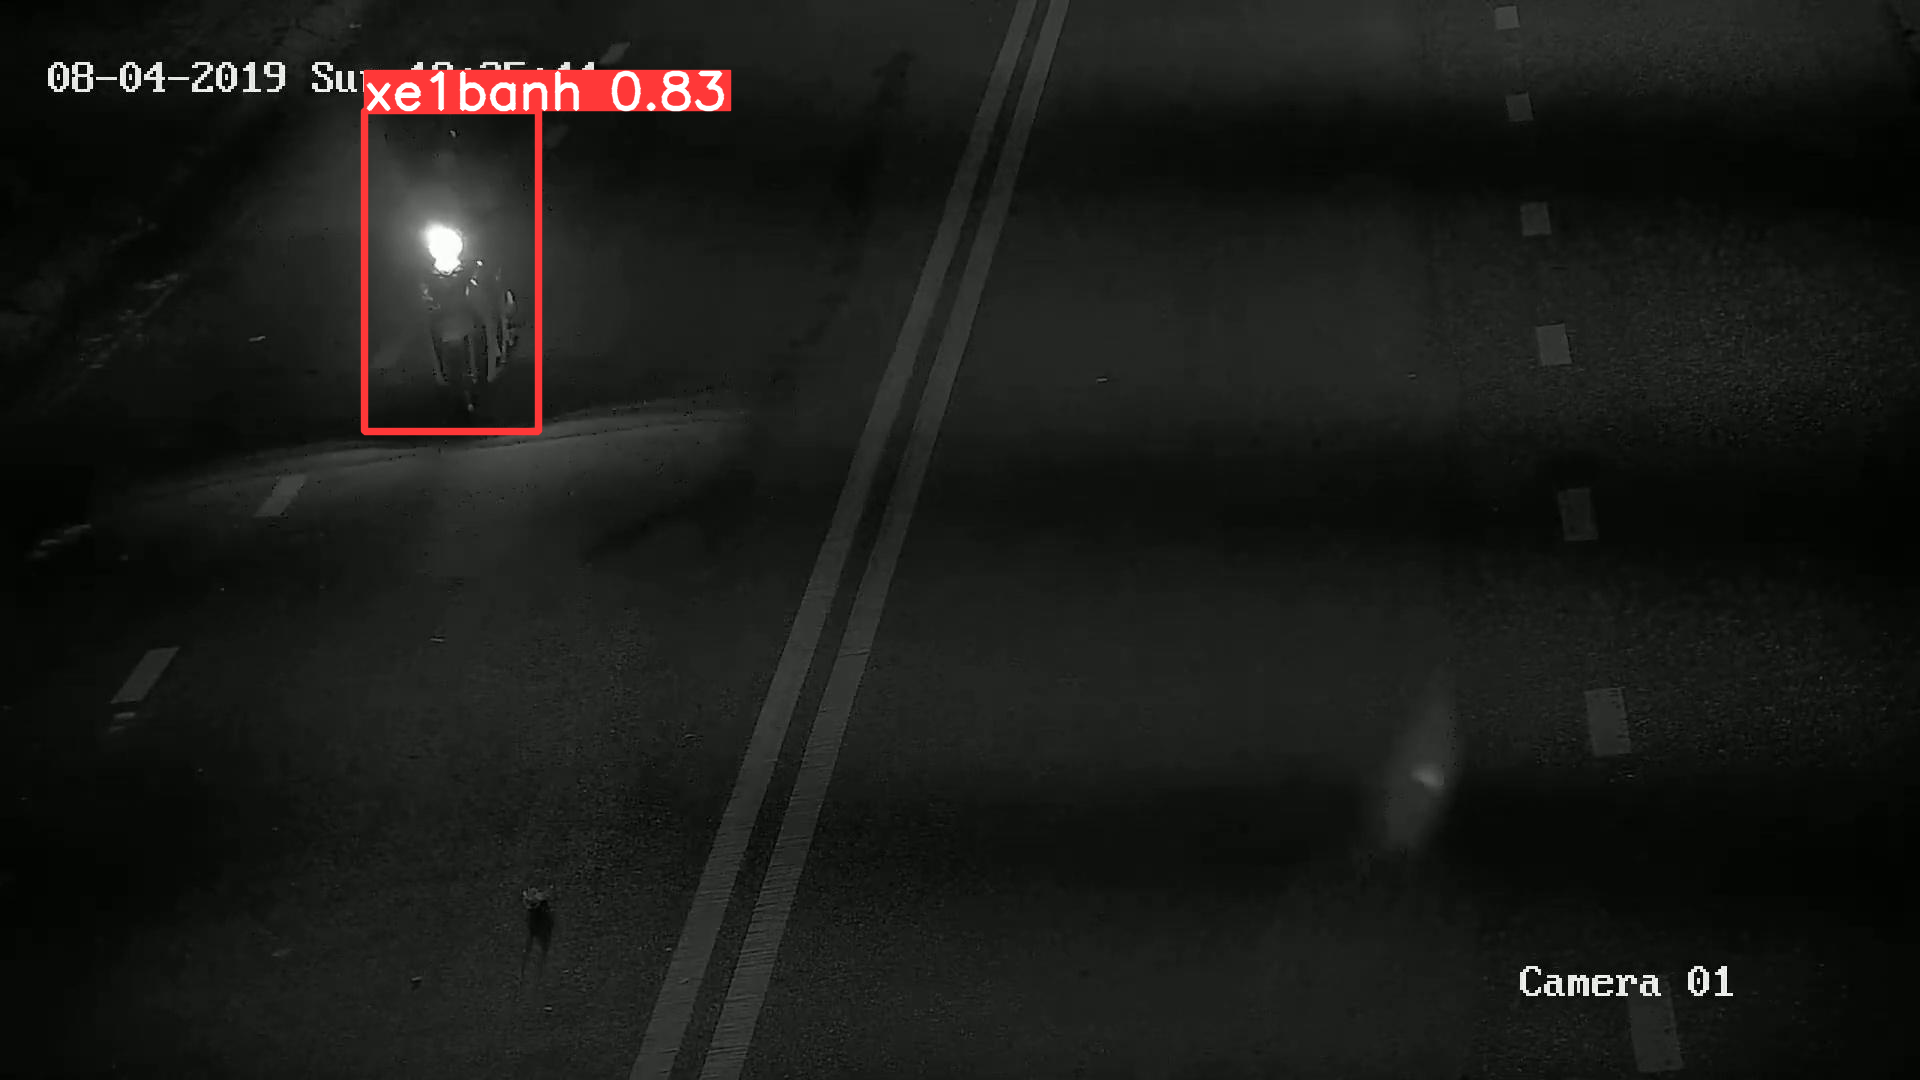

In [76]:
torch_model = YOLO("/home/bdi/Mammo_FDA/TensorRT/LP_recognition/model/car_detection.pt")

label_map = torch_model.model.names

res = torch_model("/home/bdi/Mammo_FDA/TensorRT/dataset/valid/images/frame8620_jpg.rf.9efee68b98f7b1bd96dc8ba72a547a2a.jpg", imgsz=640, conf=0.25)
Image_PIL.fromarray(res[0].plot()[:, :, ::-1])

# Export model openvino

In [19]:
torch_model.export(format="openvino", dynamic=True, half = False)

Ultralytics YOLOv8.1.15 🚀 Python-3.9.18 torch-2.2.0+cpu CPU (Intel Xeon E5-2683 v3 2.00GHz)

PyTorch: starting from '/home/bdi/Mammo_FDA/TensorRT/LP_recognition/model/car_detection.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (21.5 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 1.4s, saved as '/home/bdi/Mammo_FDA/TensorRT/LP_recognition/model/car_detection.onnx' (42.5 MB)
requirements: Ultralytics requirement ['openvino-dev>=2023.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 33.1 MB/s eta 0:00:00a 0:00:01
name:  /home/bdi/miniconda3/envs/mammo_fda/lib/python3.9/site-packages/addict  mode:  511
name:  /home/bdi/miniconda3/envs/mammo_fda/lib/python3.9/site-packages/addict  mode:  511
name:  /home/bdi/miniconda3/envs/mammo_fda/lib/python3.9/site-packages/addict-2.4.0.dist-info  mode:  511
name:  /home/bdi/miniconda3/envs/mammo_fda/lib/python3.9/site-packages/addict-2.4.0.dist-in

'/home/bdi/Mammo_FDA/TensorRT/LP_recognition/model/car_detection_openvino_model'

In [66]:
import ipywidgets as widgets
import openvino as ov

#tạo openvino runtime
core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [67]:
#tao load model openvino
# core = ov.Core()
det_ov_model = core.read_model('/home/bdi/Mammo_FDA/TensorRT/LP_recognition/model/car_detection_openvino_model/car_detection.xml')
if device.value != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
det_compiled_model = core.compile_model(det_ov_model, device.value)

In [68]:

def detect(image:np.ndarray, model:ov.Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image)
    return detections


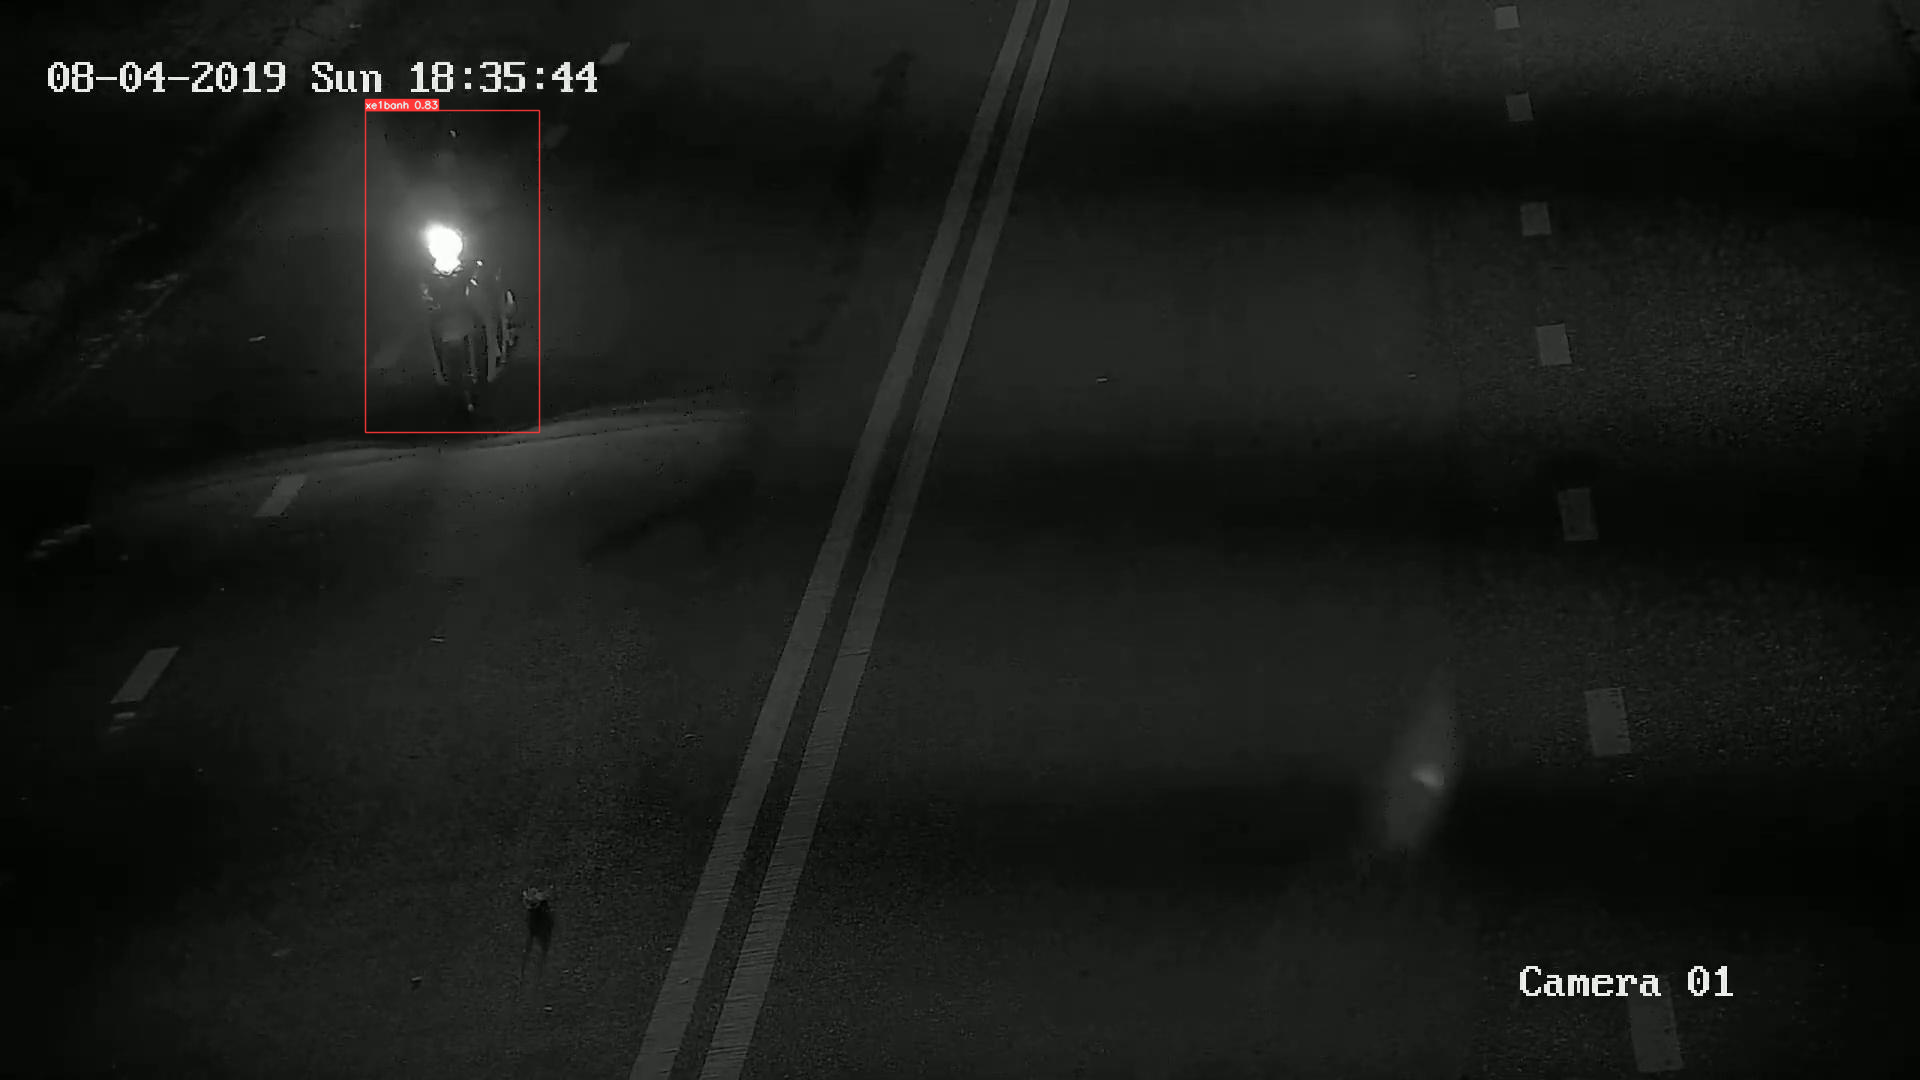

In [69]:
input_image = np.array(Image_PIL.open("/home/bdi/Mammo_FDA/TensorRT/dataset/valid/images/frame8620_jpg.rf.9efee68b98f7b1bd96dc8ba72a547a2a.jpg"))
detections = detect(input_image, det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image_PIL.fromarray(image_with_boxes)

# Valuation model

In [ ]:
def test(model:ov.Model, core:ov.Core, data_loader:torch.utils.data.DataLoader, validator, num_samples:int = None):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        validator: instance of validator class
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.batch_i = 1
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    model.reshape({0: [1, 3, -1, -1]})
    compiled_model = core.compile_model(model)
    for batch_i, batch in enumerate(tqdm(data_loader, total=num_samples)):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        results = compiled_model(batch["img"])
        preds = torch.from_numpy(results[compiled_model.output(0)])
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats

In [81]:
# test model yolov8 pytorch
validation_results = torch_model.val(data='/home/bdi/Mammo_FDA/TensorRT/dataset/data.yaml',
                               imgsz=640,
                               batch=16,
                               conf=0.25,
                               iou=0.5)

Ultralytics YOLOv8.1.15 🚀 Python-3.9.18 torch-2.2.0+cpu CPU (Intel Xeon E5-2683 v3 2.00GHz)


val: Scanning /home/bdi/Mammo_FDA/TensorRT/dataset/valid/labels... 162 images, 74 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:01<00:00, 138.60it/s]

val: New cache created: /home/bdi/Mammo_FDA/TensorRT/dataset/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:21<00:00,  1.92s/it]


                   all        162        105      0.937      0.961      0.973      0.761
               xe1banh        162         44      0.921      0.955      0.971      0.704
               xe2banh        162         61      0.952      0.967      0.976      0.818
Speed: 1.0ms preprocess, 95.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val8


In [105]:
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.utils import check_det_dataset

args = get_cfg(cfg=DEFAULT_CFG)
args.data = str("/home/bdi/Mammo_FDA/TensorRT/dataset/data.yaml")

In [106]:
det_validator = torch_model.ValidatorClass(args=args)

AttributeError: 'YOLO' object has no attribute 'ValidatorClass'

In [11]:
VIDEO_SOURCE = "/home/bdi/Mammo_FDA/TensorRT/LP_recognition/VideoCar1.mp4"

In [72]:

import collections
import time
from IPython import display


# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model=det_ov_model, device=device.value):
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect(input_image[:, :, ::-1], compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes = draw_results(detections, input_image, label_map)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

def run_object_detection_pytorch(source=0, flip=False, use_popup=False, skip_first_frames=0, model=det_ov_model, device='cpu'):
    player = None
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = model.predict(input_image[:, :, ::-1], verbose=False, device=device)
            stop_time = time.time()
            
    
            frame = detections[0].plot()[:, :, ::-1].copy()
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            
            # print(frame.shape, type(frame), frame.dtype)
            
            cv2.putText(
                img=frame ,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

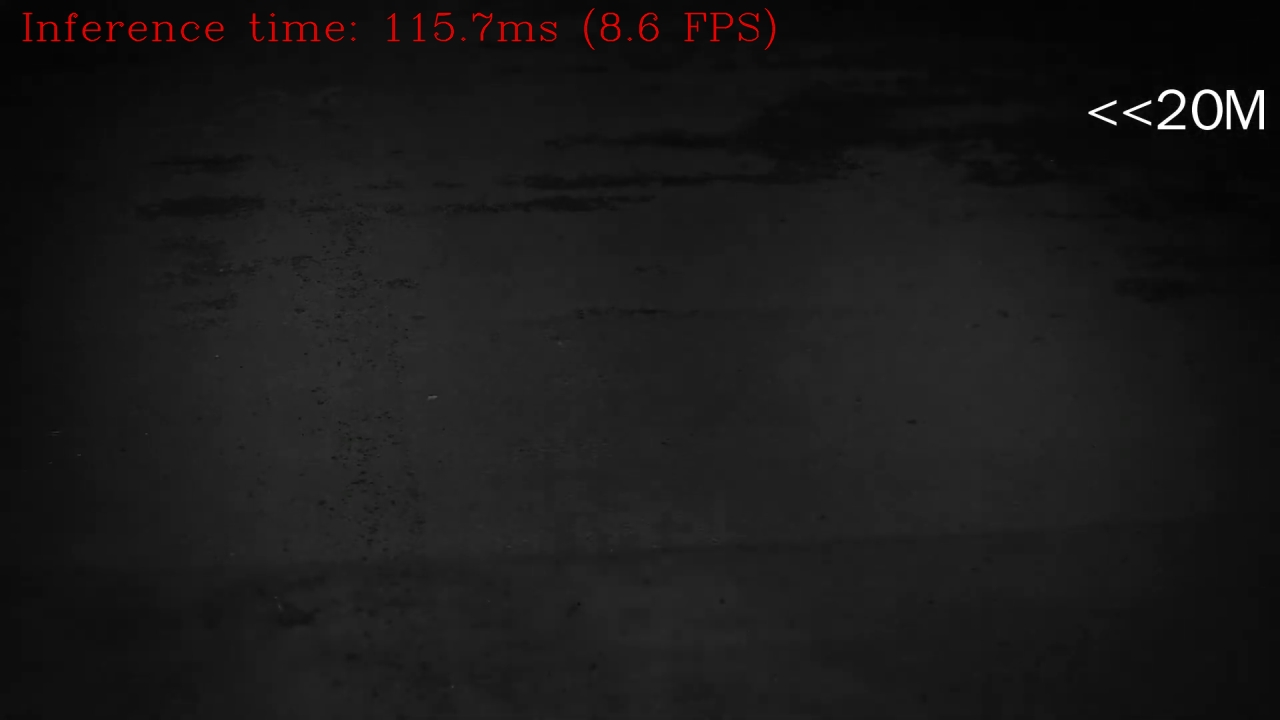

Interrupted


In [73]:
run_object_detection(source=VIDEO_SOURCE, flip=False, use_popup=False, model=det_ov_model, device=device.value)